In [1]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn.functional as F
from torch import nn, optim
from torchvision import datasets, transforms

# use GPU for computation if possible
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [2]:
# download and extract the MNIST data set
trainset = datasets.MNIST(root='./data', train=True, download=True,
                          transform=transforms.ToTensor())
testset = datasets.MNIST(root='./data', train=False, download=True,
                         transform=transforms.ToTensor())

# extract a complete PyTorch dataset
def extract(dataset):
    datasize = len(dataset)
    dataloader = torch.utils.data.DataLoader(dataset, batch_size=datasize, shuffle=False)
    return next(iter(dataloader))

# extract all training and test images and labels into PyTorch tensors
train_images, train_labels = extract(trainset)
test_images, test_labels = extract(testset)

# flatten training and test images to vectors with 28 x 28 = 784 entries
# and move to the GPU if available
train_images = train_images.view(-1, 784).to(device)
test_images = test_images.view(-1, 784).to(device)

# Variational Autoencoder

In this notebook we will train and analyze a variational autoencoder for the MNIST data set. Our goal is to perform dimensionality reduction: we reduce the high-dimensional images to a two-dimensional representation that still captures some of the important aspects of the images. We will analyze how well images can be reconstructed from the lower dimensional representations and try to generate images that look similar to the images in the MNIST data set.

## Before you start

It is strongly recommended that you complete the first part of the computer lab and perform a probabilistic PCA on the MNIST data before working through this notebook. You can download the notebook for the PPCA model [here](https://uu-sml.github.io/course-apml-public/lab/PPCA.ipynb) and run it on your computer, or you can [open it on Google Colab](https://colab.research.google.com/github/uu-sml/course-apml-public/blob/master/lab/PPCA.ipynb).

In this notebook we use [PyTorch](https://pytorch.org/), an open source software library for machine learning. Make sure that you have installed the latest version of PyTorch if you run the notebook on your computer. Alternatively, you can [open it on Google Colab](https://colab.research.google.com/github/uu-sml/course-apml-public/blob/master/lab/PPCA.ipynb), which also allows you to use GPUs which might speed up some computations.

A Jupyter notebook with an introduction to PyTorch can be downloaded from [here](https://uu-sml.github.io/course-sml-public/lab/introduction.ipynb). Alternatively, you can [open it on Google Colab](https://colab.research.google.com/github/uu-sml/course-sml-public/blob/master/lab/introduction.ipynb). Reading and running the notebook is highly recommended, since it introduces important concepts and commands that are required in this notebook.

## Motivation

Let us reflect on the limitations of PCA and PPCA. In both models, data is encoded in a lower dimensional space by a linear (or rather affine) transformation, and the lower dimensional representation can be decoded by another affine function. Is it reasonable to assume that we can generate images similar to the ones in the MNIST data set by a linear transformation of low dimensional latent variables?

One implication is that relative distances are preserved between the original space and the lower-dimensional latent space: if two data samples are "close" to each other, then also their latent encodings are relatively "close" to each other, and similarly two latent encodings that are "close" to each other are decoded to two relatively "close" data points. This affects our ability to reconstruct images from their encodings and to generate new images.

### Task

Go back to the PCA (exercise 8.1) and PPCA models. Did you observe this behaviour, i.e., were encodings of digits that look similar close to each other?  
digits that are close to each other are somewhat close to each other in the encodings although not all. For example in the 2D encoding space PPCA and PCA both gave simialr plots but the PPCA had shorter axes and could be rotated. Digits such as 7,9, and 4 were close to each other in this space and had high overlap. The digit 8 however was close to many other digits besides 0 like 2 and 6. The digit 1 wass also by itself almost completely, so some digits that are are close to each other when they look similar and other digits just might be randomly about.

## A nonlinear model

Let us consider a more flexible nonlinear model that is given by 
\begin{align*}
  p_{\boldsymbol{\theta}}(\mathbf{x} \,|\, \mathbf{z}) &= \mathcal{N}\left(\mathbf{x}; \mu_{\boldsymbol{\theta}}(\mathbf{z}), \sigma_{\boldsymbol{\theta}}^2 \mathbf{I}_{784}\right), \\
  p_{\boldsymbol{\theta}}(\mathbf{z}) &= \mathcal{N}(\mathbf{z}; \boldsymbol{0}, \mathbf{I}_2),
\end{align*}
where parameters $\boldsymbol{\theta}$ include variance parameter $\sigma^2_{\boldsymbol{\theta}} > 0$ and $\mu_{\boldsymbol{\theta}} \colon \mathbb{R}^2 \to \mathbb{R}^{784}$ is a nonlinear model of the mean of the decoding distribution. In this notebook we model $\mu_{\boldsymbol{\theta}}$ by a neural network and include its weights and biases in $\boldsymbol{\theta}$, but other models could be used equally well.

This nonlinear model is very similar to the probabilistic PCA model - the only difference is that the mean of the decoding distribution $p_{\boldsymbol{\theta}}(\mathbf{x} \,|\, \mathbf{z})$ is not a linear function of $\mathbf{z}$ (namely $\mathbf{W}z + \mu$) but a nonlinear function $\mu_{\boldsymbol{\theta}}(\mathbf{z})$ of $\mathbf{z}$.

A major implication of the nonlinearity of $\mu_{\boldsymbol{\theta}}$, and hence a major difference from the probabilistic PCA model, is: **The marginal distribution $p_{\boldsymbol{\theta}}(\mathbf{x})$ is not a normal distribution, and typically there exists no closed-form expression for it.**

Below you can see an implementation of a specific form of this nonlinear model with PyTorch. The function $\mu_{\boldsymbol{\theta}}$ is modeled by a shallow neural network (its weights and biases are included in $\boldsymbol{\theta}$). The `decode` function outputs the representative decoding $\mu_{\boldsymbol{\theta}}(\mathbf{z})$ for a batch of encodings $\mathbf{z}$.

In [3]:
class NonLinearModel(nn.Module):

    def __init__(self):
        super(NonLinearModel, self).__init__()

        # linear parts of the nonlinear function mu_theta
        self.decoder_fc1 = nn.Linear(2, 400)
        self.decoder_fc2 = nn.Linear(400, 784)

        # logarithm of variance sigma_theta^2
        self.logsigma2 = nn.Parameter(torch.zeros(1))

    def decode(self, z):
        # z is a matrix in which each row is a two-dimensional encoding
        h1 = F.relu(self.decoder_fc1(z))
        return self.decoder_fc2(h1)

### Task

Read through the definition of the nonlinear model. How is $\mu_{\boldsymbol{\theta}}(\mathbf{z})$, the mean of of the decoding distribution $p_{\boldsymbol{\theta}}(\mathbf{x} | \mathbf{z})$, defined in this model?  
The mean $\mu_{\boldsymbol{\theta}}(\mathbf{z})$ of this model is defined as single layer NN with 400 hidden units and with a relu activation function. The latent variable x of dimension 2 will be passed through this decoder by going through the shallow NN of 400 hidden units then relu then from 400 to 784 dimension output. logsigma2 is not used here.

## Training

Remember that we trained the probabilistic PCA model by minimizing the negative log-likelihood $\sum_{i=1}^N \log p_{\boldsymbol{\theta}}(\mathbf{x}_i)$ with gradient descent. However, since there is no closed-form expression of $p_{\boldsymbol{\theta}}(\mathbf{x})$ for the nonlinear model, unfortunately we can not implement and optimize the negative log-likelihood in the same straightforward way here.

Instead we optimize an approximation of the negative log-likelihood that we are able to compute: We approximate $p_{\boldsymbol{\theta}}(\mathbf{x})$ with the Monte Carlo estimate
\begin{equation}
  p_{\boldsymbol{\theta}}(\mathbf{x}) = \int p_{\boldsymbol{\theta}}(\mathbf{x} \,|\, \mathbf{z}) p_{\boldsymbol{\theta}}(\mathbf{z}) \,\mathrm{d}\mathbf{z} \approx \frac{1}{K} \sum_{n=1}^K p_{\boldsymbol{\theta}}(\mathbf{x} \,|\, \mathbf{z}_n),
\end{equation}
where $\mathbf{z}_1, \ldots, \mathbf{z}_K$ are i.i.d. samples of $\mathbf{z}$ drawn from the prior $p_{\boldsymbol{\theta}}(\mathbf{z})$. Thus we obtain
\begin{equation*}
  \begin{split}
  \log p_{\boldsymbol{\theta}}(\mathbf{x}) &\approx \log{\left(\sum_{n=1}^K \mathcal{N}(\mathbf{x}; \mu_{\boldsymbol{\theta}}(\mathbf{z}_n), \sigma_{\boldsymbol{\theta}}^2 \mathbf{I}_{784}) \right)} - \log K \\
  &= - 392 (\log \sigma_{\boldsymbol{\theta}}^2 + \log{(2\pi)}) + \log{\left(\sum_{n=1}^K \exp{\left(-\frac{1}{2\sigma_{\boldsymbol{\theta}}^2} {\|\mathbf{x} - \mu_{\boldsymbol{\theta}}(\mathbf{z}_n)\|}_2^2 \right)}\right)} - \log K.
  \end{split}
\end{equation*}
Hence similar to the probabilistic PCA model, given a training data set $\mathbf{x}_1, \ldots, \mathbf{x}_N$ we will optimize the parameters $\boldsymbol{\theta}$ by minimizing the cost function
\begin{equation*}
  J(\boldsymbol{\theta}) = 392 \log \sigma_{\boldsymbol{\theta}}^2 - \frac{1}{N} \sum_{n'=1}^N \log{\left(\sum_{n=1}^K \exp{\left(-\frac{1}{2\sigma_{\boldsymbol{\theta}}^2} {\|\mathbf{x}_{n'} - \mu_{\boldsymbol{\theta}}(\mathbf{z}_n)\|}_2^2 \right)}\right)}
\end{equation*}
with gradient descent.

### Task

Complete the following implementation `cost_function(X, model, K)` of the cost function $J(\boldsymbol{\theta})$ that takes the data matrix $\mathbf{X}$ (each row corresponds to one image), the nonlinear `model`, and the number $K$ of samples $\mathbf{z}_1, \ldots, \mathbf{z}_K$ as inputs. In the code, the sampling of $\mathbf{z}_1, \ldots, \mathbf{z}_K$ and the computation of the decodings $\mu_{\boldsymbol{\theta}}(\mathbf{z}_1), \ldots, \mu_{\boldsymbol{\theta}}(\mathbf{z}_K)$ is missing.

*Hint*: You can sample a PyTorch matrix of size $n \times m$ with standard normally distributed entries with [`torch.randn(n, m)`](https://pytorch.org/docs/stable/torch.html#torch.randn).

In [ ]:
def cost_function(X, model, K):
    # sample z_1, ..., z_K
    # WRITE YOUR CODE HERE
    #batch size x 2 or the number of samples in the latent space
    samples = torch.randn(K, 2).to(device)
    # compute matrix mu of size K x 784 whose rows are mu(z_1), ..., mu(z_K)
    # WRITE YOUR CODE HERE: mu = ...
    #to pass through the NN we can just call the model's decode function which is a forward pass
    mu = model.decode(samples)
    # compute y with y[j, i] = - 1/(2 * sigma_theta^2) * |x_j - mu_theta(z_i))|^2_2
    y = - 0.5 * torch.exp(-model.logsigma2) * (X.view(-1, 1, 784) - mu.v iew(1, -1, 784)).pow(2).sum(dim=2)
    
    # compute loss
    return 392 * model.logsigma2 - y.logsumexp(dim=1).mean()


We train the nonlinear model with stochastic gradient descent using random batches of 500 images of the MNIST training data set.

In [5]:
# define data loaders
# `pin_memory=True` is helpful when working with GPUs: https://pytorch.org/docs/stable/data.html#memory-pinning
train_data = torch.utils.data.DataLoader(
    trainset, batch_size=500, shuffle=True, pin_memory=device.type=='cuda'
)
test_data = torch.utils.data.DataLoader(
    testset, batch_size=500, pin_memory=device.type=='cuda'
)

We train the model for 20 epochs. In every iteration we use $K=5$ randomly sampled latent vectors $\mathbf{z}_1, \ldots, \mathbf{z}_K$ to estimate the cost function.

Epoch  1: training loss  -289.225, test loss  -280.205
Epoch  2: training loss  -479.210, test loss  -545.018
Epoch  3: training loss  -684.161, test loss  -678.369
Epoch  4: training loss  -691.390, test loss  -696.762
Epoch  5: training loss  -708.278, test loss  -699.832
Epoch  6: training loss  -707.778, test loss  -702.881
Epoch  7: training loss  -692.295, test loss  -700.124
Epoch  8: training loss  -715.836, test loss  -703.492
Epoch  9: training loss  -716.730, test loss  -708.477
Epoch 10: training loss  -687.547, test loss  -701.374
Epoch 11: training loss  -720.397, test loss  -703.876
Epoch 12: training loss  -724.414, test loss  -700.769
Epoch 13: training loss  -707.343, test loss  -707.661
Epoch 14: training loss  -692.261, test loss  -709.031
Epoch 15: training loss  -713.508, test loss  -700.648
Epoch 16: training loss  -712.589, test loss  -700.052
Epoch 17: training loss  -709.878, test loss  -709.610
Epoch 18: training loss  -699.854, test loss  -704.898
Epoch 19: 

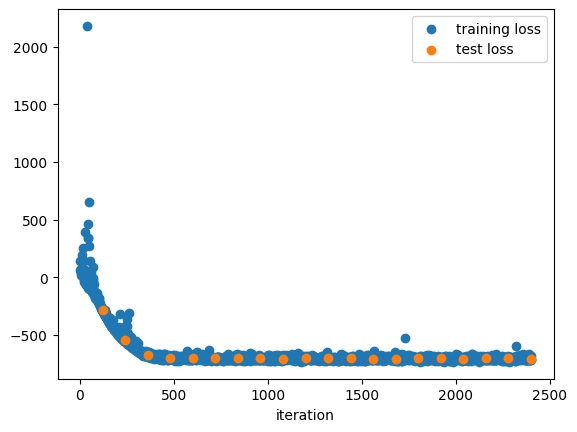

In [6]:
# define the model and move it to the GPU if available
model = NonLinearModel()
model = model.to(device)

# define the optimizer
optimizer = optim.Adam(model.parameters(), lr=0.01)

# use K = 5 samples z_1, ..., z_K
K = 5

# track the training and test loss
training_loss = []
test_loss = []

# optimize parameters for 20 epochs
for i in range(20):
    # for each minibatch
    for batch_X, _ in train_data:
        # move batch to the GPU if available
        batch_X = batch_X.to(device)

        # reset the gradient information
        optimizer.zero_grad()

        # evaluate the cost function on the training data set
        loss = cost_function(batch_X, model, K)

        # update the statistics
        training_loss.append(loss.item())
        test_loss.append(float('nan'))

        # perform backpropagation
        loss.backward()

        # perform a gradient descent step
        optimizer.step()

    # evaluate the model after every epoch
    with torch.no_grad():
        # evaluate the cost function on the test data set
        accumulated_loss = 0
        for batch_X, _ in test_data:
            # move batch to the GPU if available
            batch_X = batch_X.to(device)

            # compute loss
            loss = cost_function(batch_X, model, K)
            accumulated_loss += loss.item()

        # update the statistics
        test_loss[-1] = accumulated_loss / len(test_data)
            
    print(f"Epoch {i + 1:2d}: training loss {training_loss[-1]: 9.3f}, "
          f"test loss {test_loss[-1]: 9.3f}")
        
# plot the tracked statistics
plt.figure()
iterations = np.arange(1, len(training_loss) + 1)
plt.scatter(iterations, training_loss, label='training loss')
plt.scatter(iterations, test_loss, label='test loss')
plt.legend()
plt.xlabel('iteration')
plt.show()

### Task

Read through and try to understand the implementation of the training procedure above. Answer the following questions:

- How does it differ from the implementation of the training procedure of the probabilistic PCA model?  
The PPCA model didn't have a NN so when backpropagating through the loss function instead of going through only the cost function the training loop here also goes through the NN. So there is a forward pass in the NN that wasn't in PPCA. PPCA just constructed a graph from the loss function solely and was trying to minimize that whereas this training loop has to go through the loss function and then through a NN as well. The parameters here are the parameters of the NN as well instead of W, mu, and logsigma2 in PPCA.  

- How were the parameters initialized?  
The parameters here are initalized in the NN model. The parameters are the weights and biases from the input to hidden layer and then the weights and biases from the hidden layer to the output. There is also the logsigma2 parameter which is initialized to 0 which is the $\log\sigma^2 = 0$ so $\sigma^2$ is 1. In Pytorch the weights for a linear layer are initialized from a uniform distribution from $[-\sqrt{k},\sqrt{k}]$ where $k = \frac{1}{\text{num input features}}$ https://docs.pytorch.org/docs/stable/generated/torch.nn.Linear.html  

- What learning rate did we use in the gradient descent algorithm?  
We used a learning rate of 0.01  

- For how many iterations was the model trained?  
The model was trained for 20 epochs with 60,000 examples per epoch divided into 500 minibatches. So there were $\frac{60000}{500} = 120$ iterations per epoch which is $20*120 = 2400$ iterations

## Generating images

We can use the trained model to generate new images, in the same way as we did with the PPCA model. Again we sample 25 encodings $\mathbf{z}_1, \ldots, \mathbf{z}_{25}$ from $\mathcal{N}(\boldsymbol{0}, \mathbf{I}_{2})$, and plot their representative decodings $\mu_{\boldsymbol{\theta}}(\mathbf{z}_n)$.  
The NN does a better job of defining 0s,1s, and 9s. These digits were decoded much better than in PPCA. We can even makeout some 8s in these decodings.

In [7]:
# plot a grid of `images` with `nrows` rows and `ncols` columns
def plot_images(images, nrows=5, ncols=5):
    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(2 * ncols, 2 * nrows))
    for image, ax in zip(images, axes.flat):
        # configure subplot
        ax.set_xticks(())
        ax.set_yticks(())
        ax.grid(False)
        
        # plot image
        ax.imshow(image.view(28, 28).cpu().numpy(),
                  vmin=0.0, vmax=1.0, cmap='gray_r')
        
    return fig

torch.Size([25, 784])


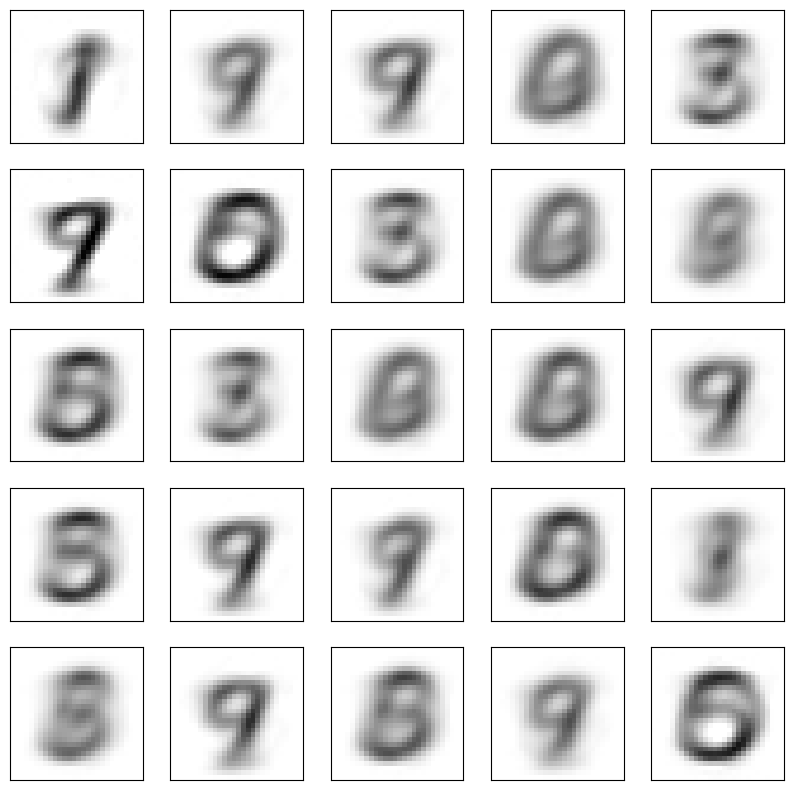

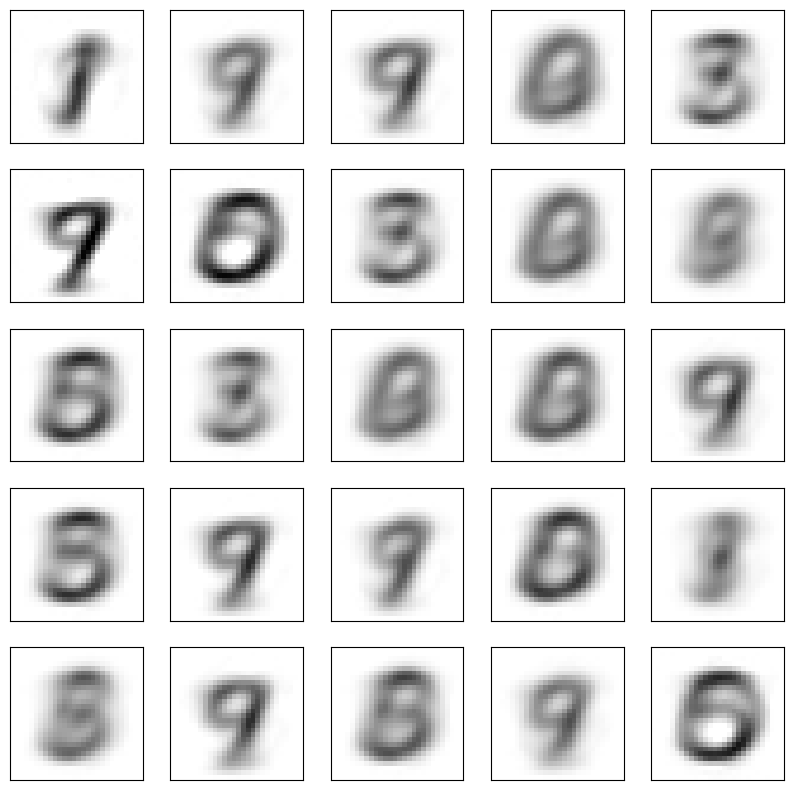

In [8]:
model.eval()
#generate 25 imageds from standard normal in the 2D latent space for task a
z_samples = torch.randn(25, 2, device=device)
z_decodings = model.decode(z_samples).detach()
print(z_decodings.shape)
plot_images(z_decodings)

### Task

When we generated images from the probabilistic PCA model, we noted that sometimes the quality of samples can be improved by tuning the temperature of the prior. Repeat the sampling with different temperatures and study how it affects the quality of the samples.

*Hint:* Check the notebook with the probabilistic PCA model for the definition of sampling with temperature.  
   
If T = 0.1 we get similar results as from the PPCA with temperatue. The images are like a mesh of a 0,8, and 9.  
If T = 0.25 we get a little more definition of 9s but still mostly just a blur.  
If T = 0.5 we get some distinct 9s and actually some 8s and the occansional 0  
If T = 0.75 we get some distinctive digits such as 0,1,8, and 9. The generation is not that bad with this temperature.  
If T = 0.9 we get similar results to T = 0.75 but the lines can be darker.

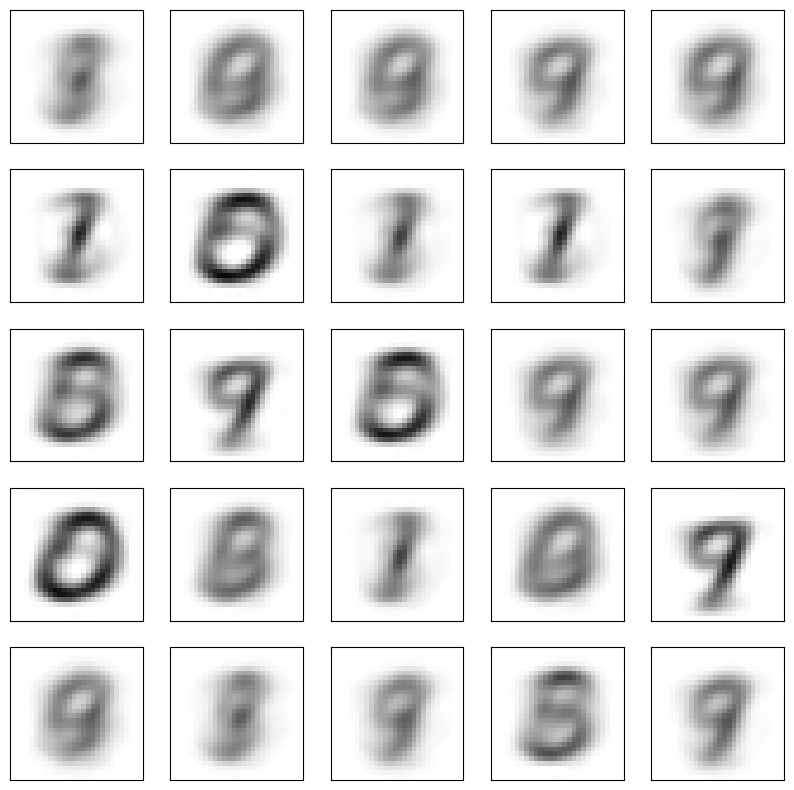

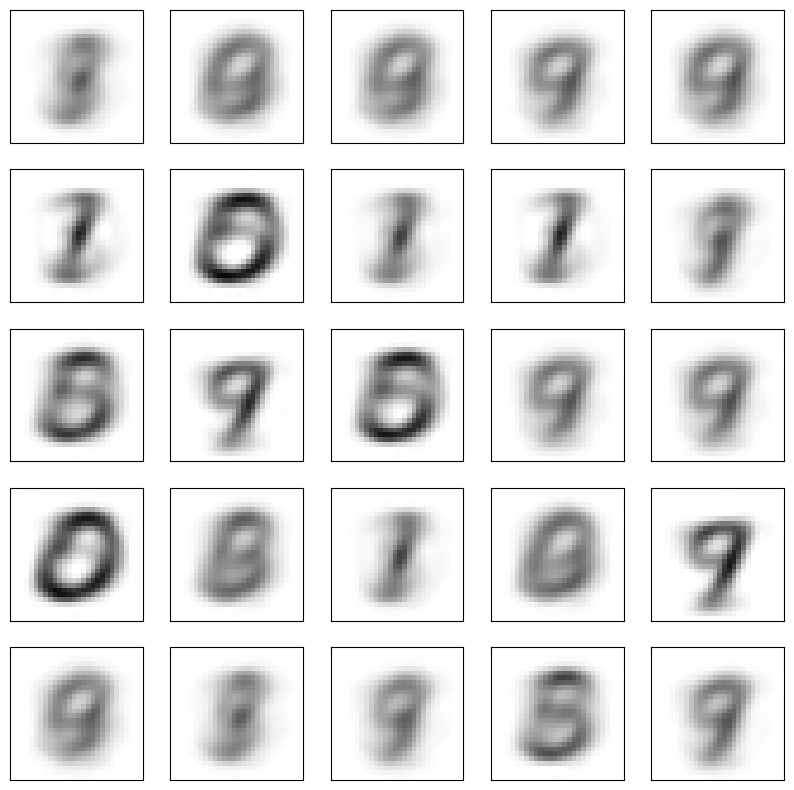

In [9]:
import torch.distributions as td
model.eval()
T = 0.75
mu_decode = torch.zeros(1, 2).to(device)
cov = (torch.tensor([[1.0, 0.0], [0.0, 1.0]]) * T**2).to(device)
mvn = td.MultivariateNormal(loc=mu_decode, covariance_matrix=cov)
samples = mvn.sample([25]).squeeze(1).to(device)

samples = model.decode(samples).detach()
plot_images(samples)

## Variational autoencoder

There is a major problem with the nonlinear model: Not only do we not know the exact form of $p_{\boldsymbol{\theta}}(\mathbf{x})$ but due to the nonlinearity of $\mu_{\boldsymbol{\theta}}(\mathbf{z})$ **we also do not know the encoding distribution** $p_{\boldsymbol{\theta}}(\mathbf{z} \,|\, \mathbf{x})$. Therefore we can not encode images in the lower dimensional latent space!

Variational autoencoders (VAEs) solve this problem by extending the nonlinear model with an encoding distribution $q_{\boldsymbol{\phi}}(\mathbf{z}; \mathbf{x})$ that may depend on $\mathbf{x}$ and some parameters $\boldsymbol{\phi}$. The distribution $q_{\boldsymbol{\phi}}(\mathbf{z}; \mathbf{x})$ is used as an approximation of $p_{\boldsymbol{\theta}}(\mathbf{z} \,|\, \mathbf{x})$. If $q_{\boldsymbol{\phi}}(\mathbf{z}; \mathbf{x})$ is a good approximation of $p_{\boldsymbol{\theta}}(\mathbf{z} \,|\, \mathbf{x})$ we can use it to compute low-dimensional representations of the data in the latent space.

Here, we study a VAE of the form
\begin{align*}
  p_{\boldsymbol{\theta}}(\mathbf{x} \,|\, \mathbf{z}) &= \mathcal{N}\left(\mathbf{x}; \mu_{\boldsymbol{\theta}}(\mathbf{z}), \sigma_{\boldsymbol{\theta}}^2 \mathbf{I}_{784}\right), \\
  p_{\boldsymbol{\theta}}(\mathbf{z}) &= \mathcal{N}(\mathbf{z}; \boldsymbol{0}, \mathbf{I}_2), \\
  q_{\boldsymbol{\phi}}(\mathbf{z}; \mathbf{x}) &= \mathcal{N}\Big(\mathbf{z}; \mu_{\boldsymbol{\phi}}(\mathbf{x}), \operatorname{diag}\big(\sigma_{\boldsymbol{\phi}}^2(\mathbf{x})\big)\Big),
\end{align*}
where, as for the nonlinear model above, parameters $\boldsymbol{\theta}$ include variance parameter $\sigma^2_{\boldsymbol{\theta}} > 0$ and $\mu_{\boldsymbol{\theta}} \colon \mathbb{R}^2 \to \mathbb{R}^{784}$ is a nonlinear model of the mean of the decoding distribution, and the encoding distribution $q_{\boldsymbol{\phi}}(\mathbf{z}; \mathbf{x})$ is a normal distribution with mean $\mu_{\boldsymbol{\phi}}(\mathbf{x}) \in \mathbb{R}^2$ and diagonal covariance matrix with diagonal elements $\sigma_{\boldsymbol{\phi}}^2(\mathbf{x})$.

The following code block defines a specific VAE. The mean and the logarithm of the diagonal entries of the covariance matrix of the encoding distributions for a batch of inputs are returned by `encode`. As above, the `decode` function outputs the mean of the decoding distributions for a batch of encodings.

In [10]:
class VAE(nn.Module):

    def __init__(self):
        super(VAE, self).__init__()

        # linear parts of the nonlinear encoder
        self.encoder_fc1 = nn.Linear(784, 400)
        self.encoder_fc2_mean = nn.Linear(400, 2)
        self.encoder_fc2_logsigma2 = nn.Linear(400, 2)

        # linear parts of the nonlinear function mu_phi
        self.decoder_fc1 = nn.Linear(2, 400)
        self.decoder_fc2 = nn.Linear(400, 784)

        # logarithm of variance sigma_phi^2
        self.logsigma2 = nn.Parameter(torch.zeros(1))

    def encode(self, X):
        """
        Return mean and log diagonal of the covariance matrix of the
        encoding distribution.
        """
        # flatten the data into a matrix with 28 x 28 = 784 columns
        X = X.view(-1, 784)
        
        h1 = F.relu(self.encoder_fc1(X))
        return self.encoder_fc2_mean(h1), self.encoder_fc2_logsigma2(h1)

    def decode(self, Z):
        """
        Return mean of the decoding distribution.
        """
        h1 = F.relu(self.decoder_fc1(Z))
        return self.decoder_fc2(h1)

### Task

Read through and try to understand the definition of the variational autoencoder. How is $\mu_{\boldsymbol{\theta}}(\mathbf{z})$, the mean of the decoding distribution $p_{\boldsymbol{\theta}}(\mathbf{x} \,|\, \mathbf{z})$ defined? How are $\mu_{\boldsymbol{\phi}}(\mathbf{x})$ and $\sigma^2_{\boldsymbol{\phi}}(\mathbf{x})$, the mean and the diagonal of the covariance matrix of the encoding distribution $q_{\boldsymbol{\phi}}(\mathbf{z}; \mathbf{x})$, defined?  


$\mu_{\boldsymbol{\theta}}(\mathbf{z})$ is the mean of the decoding distribution $p_{\boldsymbol{\theta}}(\mathbf{x} \,|\, \mathbf{z})$ and is defined the same way as above. That is it is a one hidden layer NN with the relu activation function.  
$\sigma^2_\theta$ is defined the same as a constant 0 which is the $\log\sigma^2 = 0$ so $\sigma^2$ is 1  
$\mu_{\boldsymbol{\phi}}(\mathbf{x})$ is defined as a one layer NN that goes from 784 -> 400 -> relu -> 2 that is the mean is a one layer NN with 400 hidden units and relu as the activation function.    
$\sigma^2_{\boldsymbol{\phi}}(\mathbf{x})$ is defined also as a one layer NN from 784 -> 400 -> relu -> 2. For the encoder the mean and diagonal both go through the same first hidden layer. So both go through 784 -> 400 -> relu. These parameters are shared between the mean and std; however, the mean and std have differnet linear layers for the output layer so from relu -> 2 they are different layers. So the input goes through the input of 784 to a layer of 400 then this 400 is relu'd and then passed to the output layer through two different 400 -> 2 layers for the mean and std.

## Training

When we train the VAE we have to optimize both the parameters $\boldsymbol{\theta}$ of the nonlinear model and the parameters $\boldsymbol{\phi}$ of the encoding distribution $q_{\boldsymbol{\phi}}(\mathbf{z}; \mathbf{x})$. 
If we manage that distribution $q_{\boldsymbol{\phi}}(\mathbf{z}; \mathbf{x})$ becomes equal to the distribution $p_{\boldsymbol{\theta}}(\mathbf{z} \,|\, \mathbf{x})$ (or at least close to it), we have found a way to encode our data: for a given data sample $\mathbf{x}$, we can just sample the latent encoding from $q_{\boldsymbol{\phi}}(\mathbf{z}; \mathbf{x})$.

### Theoretical background

For all $\mathbf{x}$ we have  
\begin{equation*}
    \log p_{\boldsymbol{\theta}}(\mathbf{x}) =
    \mathbb{E}_{\mathbf{z} \sim q_{\boldsymbol{\phi}}(\mathbf{z}; \mathbf{x})}\big[\log p_{\boldsymbol{\theta}}(\mathbf{x} \,|\, \mathbf{z})\big]
    + \mathrm{KL}\big(q_{\boldsymbol{\phi}}(\mathbf{z}; \mathbf{x}) \,\big\|\, p_{\boldsymbol{\theta}}(\mathbf{z} \,|\,\mathbf{x})\big) - \mathrm{KL}\big(q_{\boldsymbol{\phi}}(\mathbf{z}; \mathbf{x}) \,\big\|\, p_{\boldsymbol{\theta}}(\mathbf{z})\big),
\end{equation*}  
(we ignore here that the KL-divergence $\mathrm{KL}(p \,\|\, q)$ is only defined if $q(x) = 0$ implies $p(x) = 0$).

The KL divergence of two distributions is always non-negative, and zero if and only if the two distributions are equal. Hence we have for all $\mathbf{x}$
$$
  \log p_{\boldsymbol{\theta}}(\mathbf{x}) \geq
  \underbrace{\mathbb{E}_{\mathbf{z} \sim q_{\boldsymbol{\phi}}(\mathbf{z}; \mathbf{x})}\big[\log p_{\boldsymbol{\theta}}(\mathbf{x} \,|\, \mathbf{z})\big]
  - \mathrm{KL}\big(q_{\boldsymbol{\phi}}(\mathbf{z}; \mathbf{x}) \,\big\|\, p_{\boldsymbol{\theta}}(\mathbf{z})\big)}_{\text{evidence lower bound (ELBO)}}
$$
with equality if and only if $q_{\boldsymbol{\phi}}(\mathbf{z}; \mathbf{x})$ is equal to
the distribution $p_{\boldsymbol{\theta}}(\mathbf{z} \,|\, \mathbf{x})$. Since the
right-hand side of this inequality is a lower bound of the (log) evidence $\log p_{\boldsymbol{\theta}}(\mathbf{x})$, it is called **evidence lower bound (ELBO)**.

The ELBO can not be evaluated exactly but it can be estimated:
1. The first term $\mathbb{E}_{\mathbf{z} \sim q_{\boldsymbol{\phi}}(\mathbf{z}; \mathbf{x})}\big[\log p_{\boldsymbol{\theta}}(\mathbf{x} \,|\, \mathbf{z})\big]$ can be estimated with the Monte Carlo estimate
   \begin{equation*}
       \frac{1}{K} \sum_{i=1}^K \log p_{\boldsymbol{\theta}}(\mathbf{x} \,|\, \mathbf{z}_i)
   \end{equation*}
   where $\mathbf{z}_1,\ldots,\mathbf{z}_K$ are i.i.d. samples from $q_{\boldsymbol{\phi}}(\mathbf{z}; \mathbf{x})$.
2. From the preparatory exercises we know that for our choices of $p_{\boldsymbol{\theta}}(\mathbf{z})$ and $q_{\boldsymbol{\phi}}(\mathbf{z}; \mathbf{x})$ the second term is
   \begin{equation*}
       \mathrm{KL}\big(q_{\boldsymbol{\phi}}(\mathbf{z}; \mathbf{x}) \,\big\|\, p_{\boldsymbol{\theta}}(\mathbf{z})\big) = \frac{1}{2} \left(\sum_{n=1}^2 (\sigma_{\boldsymbol{\phi}}^2(\mathbf{x}))_n + \|\mu_{\boldsymbol{\phi}}(\mathbf{x})\|^2_2 - 2 - \sum_{n=1}^2 \log (\sigma_{\boldsymbol{\phi}}^2(\mathbf{x}))_n\right).
   \end{equation*}
   Since the form of the prior $p_{\boldsymbol{\theta}}(\mathbf{z})$ and $q_{\boldsymbol{\phi}}(\mathbf{z}; \mathbf{x})$ are design choices, usually we can choose them such that there is a closed-form expression for the second term of the ELBO.

What is the advantage of the ELBO over the evidence $\log p_{\boldsymbol{\theta}}(\mathbf{x})$ if one has to use a Monte Carlo estimate as well?

The fundamental difference is that in the estimation of the ELBO the Monte Carlo samples $\mathbf{z}_1, \ldots, \mathbf{z}_K$ are sampled from $q_{\boldsymbol{\phi}}(\mathbf{z}; \mathbf{x})$ instead of $p_{\boldsymbol{\theta}}(\mathbf{z}) = \mathcal{N}(\mathbf{z}; \boldsymbol{0}, \mathbf{I}_2)$: We can tune the parameters $\boldsymbol{\phi}$ such that the terms $p_{\boldsymbol{\theta}}(\mathbf{x} \,|\, \mathbf{z}_i)$ in the Monte Carlo estimate increase (intuitively, it becomes more likely to reconstruct $\mathbf{x}$ from the samples $\mathbf{z}_i$, and hence more terms of the Monte Carlo estimate actually contribute to the estimate.

This observation motivates the idea of maximizing the ELBO by training parameters $\boldsymbol{\theta}$ and $\boldsymbol{\phi}$ simultaneously instead of maximizing the evidence $\log p_{\boldsymbol{\theta}}(\mathbf{x})$ directly by training only $\boldsymbol{\theta}$. If the encoding distribution is flexible enough, we might even be able to obtain $q_{\boldsymbol{\phi}}(\mathbf{z}; \mathbf{x}) = p_{\boldsymbol{\theta}}(\mathbf{z} \,|\, \mathbf{x})$, in which case the ELBO is equal to the evidence.

### Cost function

Let our training data $\mathbf{x}_1, \ldots, \mathbf{x}_N$ be i.i.d. samples of $\mathbf{x}$. Then the
joint ELBO, i.e., the sum of the ELBOs for $\mathbf{x}_1, \ldots, \mathbf{x}_N$ separately, is a lower
bound of
\begin{equation*}
    \log p_{\boldsymbol{\theta}}(\mathbf{x}_1, \ldots, \mathbf{x}_N) = \sum_{n=1}^N \log p_{\boldsymbol{\theta}}(\mathbf{x}_n).
\end{equation*}
For our choices of $p_{\boldsymbol{\theta}}(\mathbf{z})$ and $q_{\boldsymbol{\phi}}(\mathbf{z}; \mathbf{x})$ the joint ELBO can be estimated by
\begin{equation*}
    \begin{split}
    & - \frac{1}{2}\left(784 N \left(\log{(2\pi)} + \log{\sigma_{\boldsymbol{\theta}}^2})\right) + \frac{1}{\sigma_{\boldsymbol{\theta}}^2}\sum_{n=1}^N \frac{1}{K} \sum_{n'=1}^K \|\mu_{\boldsymbol{\theta}}(\mathbf{z}_{n,n'}) - \mathbf{x}_n\|^2_2 \right) \\
    & - \frac{1}{2} \sum_{n=1}^N \sum_{i=1}^2 \left( (\sigma_{\boldsymbol{\phi}}^2(\mathbf{x}_n))_i + (\mu_{\boldsymbol{\phi}}(\mathbf{x}_n))^2_i - 1 - \log (\sigma_{\boldsymbol{\phi}}^2(\mathbf{x}_n))_i\right),
     \end{split}
\end{equation*}
where $\mathbf{z}_{n,1}, \ldots, \mathbf{z}_{n,K}$ are independent samples of the encoding distribution $q_{\boldsymbol{\phi}}(\mathbf{z}; \mathbf{x}) = \mathcal{N}(\mathbf{z}; \mu_{\boldsymbol{\phi}}(\mathbf{x}_n), \mathrm{diag}(\sigma_{\boldsymbol{\phi}}^2(\mathbf{x}_n)))$.

Since we use a stochastic optimization algorithm anyway, we choose $K = 1$, i.e., we use only one Monte Carlo sample for each training data sample. After neglecting additive constant terms and scaling by $N/2$, we obtain the cost function
\begin{equation*}
 J(\boldsymbol{\theta}, \boldsymbol{\phi}) = 784 \log{\sigma_{\boldsymbol{\theta}}^2} + \frac{1}{N \sigma_{\boldsymbol{\theta}}^2} \sum_{n=1}^N  \|\mu_{\boldsymbol{\theta}}(\mathbf{z}_n) - \mathbf{x}_n\|^2_2 + \frac{1}{N} \sum_{n=1}^N \sum_{i=1}^2 \left( (\sigma_{\boldsymbol{\phi}}^2(\mathbf{x}_n))_i + (\mu_{\boldsymbol{\phi}}(\mathbf{x}_n))^2_i - \log (\sigma_{\boldsymbol{\phi}}^2(\mathbf{x}_n))_i\right),
\end{equation*}
where $\mathbf{z}_n$ are samples from $q_{\boldsymbol{\phi}}(\mathbf{z}; \mathbf{x}) = \mathcal{N}(\mathbf{z}; \mu_{\boldsymbol{\phi}}(\mathbf{x}_n), \mathrm{diag}(\sigma_{\boldsymbol{\phi}}^2(\mathbf{x}_n)))$. We will minimize this cost function with stochastic gradient descent.

### Reparameterization trick

However, there is one problem: it is not immediately clear how to differentiate through the sampling operation of $\mathbf{z}_n$ with respect to the parameters $\boldsymbol{\phi}$ that determine the mean and variance of the distribution we sample from.

The solution is: We can draw a sample $\mathbf{z}_n$ from $q_{\boldsymbol{\phi}}(\mathbf{z}; \mathbf{x}) = \mathcal{N}(\mathbf{z}; \mu_{\boldsymbol{\phi}}(\mathbf{x}_n), \mathrm{diag}(\sigma_{\boldsymbol{\phi}}^2(\mathbf{x}_n)))$ by sampling $\boldsymbol{\epsilon}_n$ from the normal distribution $\mathcal{N}(\boldsymbol{0}, \mathbf{I}_2)$ and setting $\mathbf{z}_n = \mu_{\boldsymbol{\phi}}(\mathbf{x}_n) + \mathrm{diag}(\sigma_{\boldsymbol{\phi}}^2(\mathbf{x}_n)) \boldsymbol{\epsilon}_n$.

Thus we can rewrite the cost function as
\begin{equation*}
    \begin{split}
 J(\boldsymbol{\theta}, \boldsymbol{\phi}) &= 784 \log{\sigma_{\boldsymbol{\theta}}^2} + \frac{1}{N \sigma_{\boldsymbol{\theta}}^2} \sum_{n=1}^N  \|\mu_{\boldsymbol{\theta}}(\mu_{\boldsymbol{\phi}}(\mathbf{x}_n) + \mathrm{diag}(\sigma_{\boldsymbol{\phi}}(\mathbf{x}_n)) \boldsymbol{\epsilon}_n) - \mathbf{x}_n\|^2_2 \\
 &\quad + \frac{1}{N} \sum_{n=1}^N \sum_{i=1}^2 \left( (\sigma_{\boldsymbol{\phi}}^2(\mathbf{x}_n))_i + (\mu_{\boldsymbol{\phi}}(\mathbf{x}_n))^2_i - \log (\sigma_{\boldsymbol{\phi}}^2(\mathbf{x}_n))_i\right),
 \end{split}
\end{equation*}
where $\boldsymbol{\epsilon}_n$ are samples from the normal distribution $\mathcal{N}(\boldsymbol{0}, \mathbf{I}_2)$. Rewriting the cost function in this form is known as reparameterization trick and allows us to differentiate the cost function with respect to $\boldsymbol{\phi}$ in a straightforward way, since the samples $\boldsymbol{\epsilon}_n$ do not depend on the parameters anymore.

### Task

Complete the following implementation `cost_function(X, model)` of the cost function $J(\boldsymbol{\theta})$ that takes the data matrix $\mathbf{X}$ (each row corresponds to one image) and the nonlinear `model` as inputs. In the code, the computation of the term
\begin{equation}
\frac{1}{N} \sum_{n=1}^N \sum_{i=1}^2 \left( (\sigma_{\boldsymbol{\phi}}^2(\mathbf{x}_n))_i + (\mu_{\boldsymbol{\phi}}(\mathbf{x}_n))^2_i - \log (\sigma_{\boldsymbol{\phi}}^2(\mathbf{x}_n))_i\right),
\end{equation}
that originates from the KL divergence expression in the ELBO, is missing.

*Hint*: You can make use of the PyTorch functions [`torch.mean`](https://pytorch.org/docs/stable/torch.html#torch.mean), [`torch.sum`](https://pytorch.org/docs/stable/torch.html#torch.sum), [`torch.exp`](https://pytorch.org/docs/stable/torch.html#torch.exp), and [`torch.pow`](https://pytorch.org/docs/stable/torch.html#torch.pow) in your implementation.

In [11]:
def cost_function(X, model):
    # compute mean and log variance of the encoding distribution for input X
    Z_mu, Z_logsigma2 = model.encode(X)
    # print("Z_mu shape:", Z_mu.shape)
    # print("Z_logsigma2:", Z_logsigma2.shape)
    # compute the average KL divergence to the prior standard normal
    # distribution of z, neglecting additive constant terms
    # expected log p(x | z) + C
    # WRITE YOUR CODE HERE
    kl = torch.sum(torch.exp(Z_logsigma2) + Z_mu.pow(2) - Z_logsigma2, dim=1).mean()

    # sample encodings Z
    Z = Z_mu + torch.exp(0.5 * Z_logsigma2) * torch.randn_like(Z_logsigma2)

    # compute the (mean) decodings of Z
    X_decodings = model.decode(Z)

    # compute negative average log evidence of the input X, neglecting additive constant terms
    neg_log_evidence = 784 * model.logsigma2 + \
        torch.sum((X_decodings - X.view(-1, 784)).pow(2) * torch.exp(- model.logsigma2), dim=1).mean()

    return neg_log_evidence + kl


Now we can train the nonlinear model.

Epoch  1: training loss  -337.980, test loss  -343.174
Epoch  2: training loss  -919.342, test loss  -927.107
Epoch  3: training loss -1350.841, test loss -1351.661
Epoch  4: training loss -1524.336, test loss -1545.096
Epoch  5: training loss -1601.484, test loss -1603.050
Epoch  6: training loss -1628.607, test loss -1616.380
Epoch  7: training loss -1615.507, test loss -1631.599
Epoch  8: training loss -1626.301, test loss -1644.400
Epoch  9: training loss -1646.181, test loss -1652.491
Epoch 10: training loss -1649.812, test loss -1658.300
Epoch 11: training loss -1686.265, test loss -1663.503
Epoch 12: training loss -1671.182, test loss -1657.072
Epoch 13: training loss -1640.336, test loss -1668.652
Epoch 14: training loss -1671.583, test loss -1679.086
Epoch 15: training loss -1689.036, test loss -1681.316
Epoch 16: training loss -1687.603, test loss -1680.769
Epoch 17: training loss -1704.652, test loss -1687.286
Epoch 18: training loss -1711.997, test loss -1686.398
Epoch 19: 

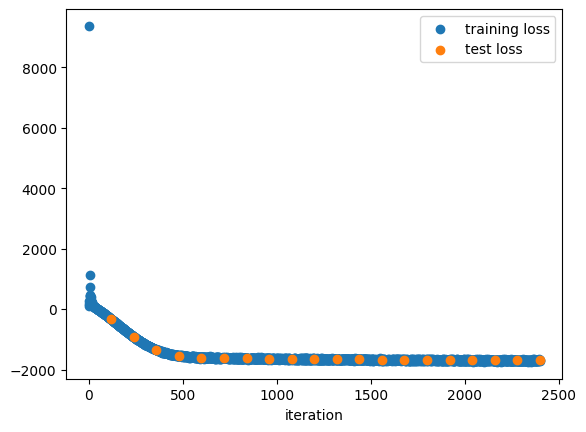

In [12]:
# define the model and move it to the GPU if available
model = VAE()
model = model.to(device)

# define the optimizer
optimizer = optim.Adam(model.parameters(), lr=0.01)

# track the training and test loss
training_loss = []
test_loss = []

# optimize parameters for 20 epochs
for i in range(20):
    # for each minibatch
    for batch_X, _ in train_data:
        # move batch to the GPU if available
        batch_X = batch_X.to(device)

        # reset the gradient information
        optimizer.zero_grad()

        # evaluate the cost function on the training data set
        loss = cost_function(batch_X, model)

        # update the statistics
        training_loss.append(loss.item())
        test_loss.append(float('nan'))

        # perform backpropagation
        loss.backward()

        # perform a gradient descent step
        optimizer.step()

    # evaluate the model after every epoch
    with torch.no_grad():
        # evaluate the cost function on the test data set
        accumulated_loss = 0
        for batch_X, _ in test_data:
            # move batch to the GPU if available
            batch_X = batch_X.to(device)

            # compute loss
            loss = cost_function(batch_X, model)
            accumulated_loss += loss.item()

        # update the statistics
        test_loss[-1] = accumulated_loss / len(test_data)
            
    print(f"Epoch {i + 1:2d}: training loss {training_loss[-1]: 9.3f}, "
          f"test loss {test_loss[-1]: 9.3f}")
        
# plot the tracked statistics
plt.figure()
iterations = np.arange(1, len(training_loss) + 1)
plt.scatter(iterations, training_loss, label='training loss')
plt.scatter(iterations, test_loss, label='test loss')
plt.legend()
plt.xlabel('iteration')
plt.show()

### Task

Read through and try to understand the implementation of the training procedure above. Answer the following questions:

- How does it differ from the implementation of the training procedure of the nonlinear model above?  
This training differs from the training of the non linear model in the cost function. This model runs gradient descent on both the encoding and decoding models at the same time. 

- How were the parameters initialized?  
For the linear layers the paratemeters were initialized from a uniform distribution from $[-\sqrt{k},\sqrt{k}]$ where $k = \frac{1}{\text{num input features}}$ https://docs.pytorch.org/docs/stable/generated/torch.nn.Linear.html. This includes the both the $\mu_\phi$ and $\sigma^2_phi$ of the encoder and the $\mu_\theta$ of the decoder. $\log\sigma^2_\theta$ is set to 0 which means $\sigma^2_\theta$ is 1
- What learning rate did we use in the gradient descent algorithm?  
We used a learning rate of 0.01

- For how many iterations was the model trained?  
The model was trained for 20 epochs with 60,000 examples per epoch divided into 500 minibatches. So there were $\frac{60000}{500} = 120$ iterations per epoch which is $20*120 = 2400$ iterations

## Encodings

In contrast to the regular nonlinear model without encoder, the VAE allows us to encode the images of the MNIST data set in the two-dimensional latent space.

Similar to probabilistic PCA, there exists not one unique representation of an image in the latent space but instead each image $\mathbf{x}$ gives rise to a whole distribution $q_{\boldsymbol{\phi}}(\mathbf{z}; \mathbf{x})$ of representations in the latent space. Here we use the mean $\mu_{\boldsymbol{\phi}}(\mathbf{x})$ of the encoding distribution as encoding. Alternatively, one could e.g. sample from the encoding distribution.

### Task

Compute the two-dimensional encodings $\mu_{\boldsymbol{\phi}}(\mathbf{x})$ of the images in the MNIST training and test data sets. Make use of the function `plot_encodings` below and visualize them with 2D scatter plots.

In [13]:
# plot `train_encodings` and `test_encodings` with colorcoding of the corresponding labels
def plot_encodings(train_encodings, train_labels, test_encodings, test_labels):
    # create two plots side by side
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 6))

    # plot encodings of training data
    ax = axes[0]
    ax.scatter(
        train_encodings[:, 0].cpu().numpy(), train_encodings[:, 1].cpu().numpy(),
        c=train_labels, cmap=plt.cm.tab10, vmin=-0.5, vmax=9.5, alpha=0.7
    )
    ax.set_xlabel("$z_1$")
    ax.set_ylabel("$z_2$")
    ax.set_title("training data")
    
    # plot encodings of test data
    ax = axes[1]
    scatter = ax.scatter(
        test_encodings[:, 0].cpu().numpy(), test_encodings[:, 1].cpu().numpy(),
        c=test_labels, cmap=plt.cm.tab10, vmin=-0.5, vmax=9.5, alpha=0.7
    )
    ax.set_xlabel("$z_1$")
    ax.set_ylabel("$z_2$")
    ax.set_title("test data")

    # add colorbar
    cb = fig.colorbar(scatter, ticks=range(10), ax=axes.ravel().tolist())
    cb.ax.set_title("digit")
    
    return fig

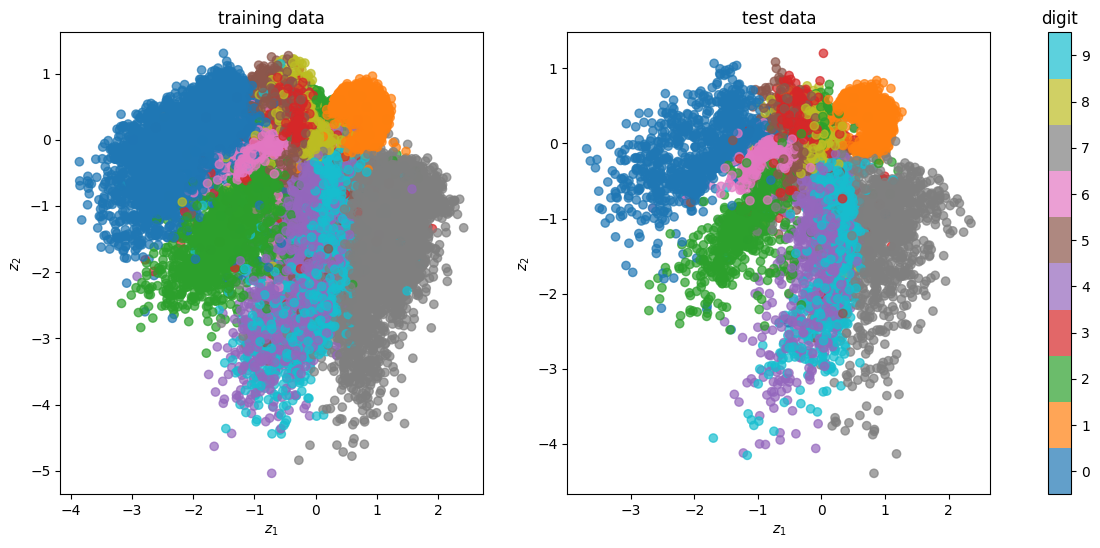

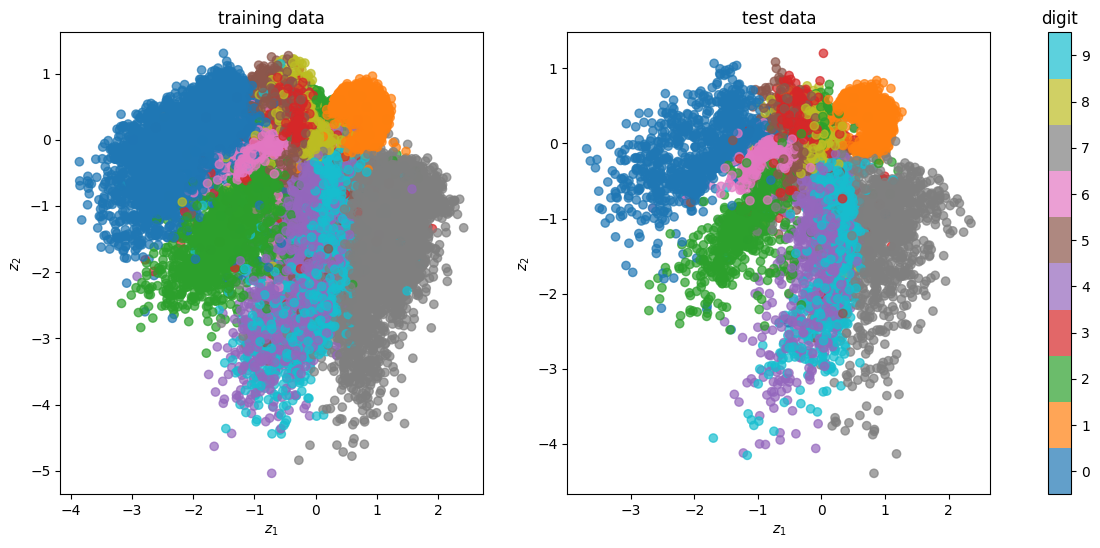

In [14]:
model.eval()
train_encodings, _ = model.encode(train_images)
test_encodings, _ = model.encode(test_images)
train_encodings = train_encodings.detach()
test_encodings = test_encodings.detach()
plot_encodings(train_encodings, train_labels, test_encodings, test_labels)

### Task

Compare the encodings of the test images with the encodings for regular PCA in exercise 8.1 and probabilistic PCA. Are they different and, if yes, in what ways?  
The encodings of the data with the VAE are much different when compared to the PPCA setting. The data is more in a flower like shape and we get a much more clear separation of the classes and classes that are close together are close together more clearly in the encoding space. For example 1 is separated but closest to 7 and 9, 0 is very close to 6. but 2,5, and 8 are more scattered about but the digits 0,1,7,9,4,6,3 have much more defined regions.

## Decodings

Of course, we can also decode the representations in the latent space according to the definition of
the decoding distribution
\begin{equation*}
  p_{\boldsymbol{\theta}}(\mathbf{x} \,|\, \mathbf{z}) = \mathcal{N}\left(\mathbf{x}; \mu_{\boldsymbol{\theta}}(\mathbf{z}), \sigma_{\boldsymbol{\theta}}^2 \mathbf{I}_{784}\right).
\end{equation*}
Analogously to the encodings discussed above and the probabilistic PCA model, here we take the mean $\mu_{\boldsymbol{\theta}}(\mathbf{z})$ of the decoding distribution as decoding of $\mathbf{z}$. Alternatively we could e.g. sample from the decoding distribution.

### Task

Compute the reconstructions of the test images by mapping the encodings of the test data from the latent space back to the space of images.

In [15]:
model.eval()
train_decodings = model.decode(train_encodings)
test_decodings = model.decode(test_encodings)
train_decodings = train_decodings.detach()
test_decodings = test_decodings.detach()    


### Task

As in the previous parts of the lab session, we compare the test images with their reconstructions to see how much information we lose by encoding the MNIST images in a two-dimensional space. Plot a set of images and their reconstructions with the function `plot_reconstructions` below.

In [16]:
# plot a grid of random pairs of `originals` and `reconstructions`
def plot_reconstructions(originals, reconstructions, labels, num_rows=4, num_cols=2):
    # indices of displayed samples
    n = originals.shape[0]
    indices = np.random.choice(n, size=num_rows*num_cols, replace=False)

    fig, axes = plt.subplots(nrows=num_rows, ncols=num_cols, figsize=(10, 10))
    for (idx, ax) in zip(indices, axes.flat):
        # extract original, reconstruction, and label
        original = originals[idx]
        reconstruction = reconstructions[idx]
        label = labels[idx]

        # configure subplot
        ax.set_xticks(())
        ax.set_yticks(())
        ax.grid(False)
        ax.set_title(f"Label: {label.item()}", fontweight='bold')

        # plot original and reconstructed image in a grid
        grid = np.ones((32, 62))
        grid[2:30, 2:30] = original.view(28, 28).cpu().numpy()
        grid[2:30, 32:60] = reconstruction.view(28, 28).cpu().numpy()
        ax.imshow(grid, vmin=0.0, vmax=1.0, cmap='gray_r')

    return fig

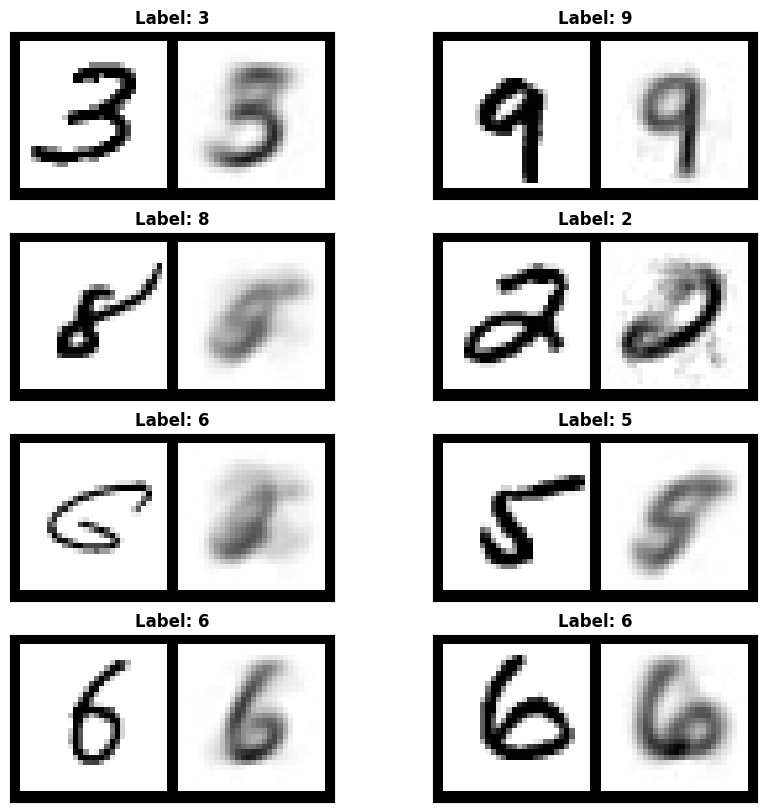

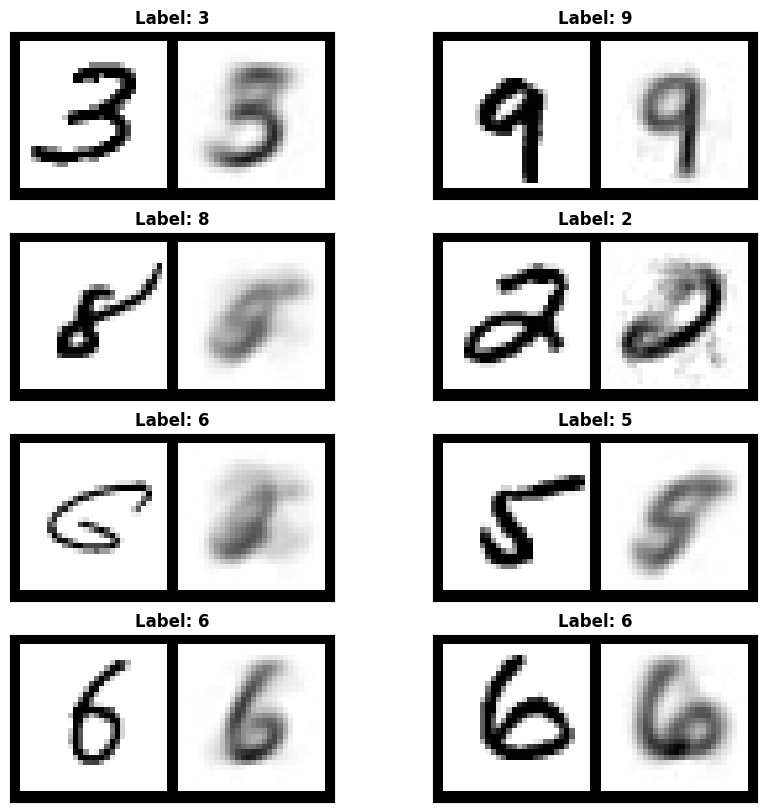

In [17]:
plot_reconstructions(test_images, test_decodings, test_labels)

### Task

Compute the average squared reconstruction error
\begin{equation*}
    \mathrm{sqerr} := \frac{1}{10000} \sum_{i=1}^{10000} \|\mathbf{x}_i - \tilde{\mathbf{x}}_i\|^2_2
\end{equation*}
of the images $\mathbf{x}_i \in {[0,1]}^{784}$ and their reconstructions $\tilde{\mathbf{x}}_i \in \mathbb{R}^{784}$ ($i = 1,\ldots, 10000$) in the MNIST test data set as an objective measure for the quality of the reconstructions.

In [18]:
print("test encodings", test_images.shape)
print("reconstructed", test_decodings.shape)
error = ((test_images - test_decodings)**2).sum(axis=1).mean()
print("error", error)

test encodings torch.Size([10000, 784])
reconstructed torch.Size([10000, 784])
error tensor(32.1950, device='cuda:0')


### Task

Now we have performed exactly the same analysis as for the regular PCA in exercise 8.1 and the probabilistic PCA. Compare the results you obtained with regular PCA, probabilistic PCA, and the VAE, and answer the following questions:
- Which digits can be reconstructed and decoded quite well, and which ones seem to be more challenging? Are there differences between the three approaches?  
The VAE does much better across the board in terms of resconstruction error and a visual check. VAE is able to reconstruct 0,1,5,9,2,4, and 7 quite decently well. 2 is a bit harder. Whereas PCA and PPCA could really only encode then decode 0,1, and 9 well. PCA is more ridged in the approach and is easier to implement but returns the worst results. PPCA is a bit more complex but allows us to draw samples from a distribution and is a little better than PCA. VAE is the best and is also the most complicated. It has nonlinear encodings and decodings that are training at the same time. This makes it the most effective model but also the most complicated. With PPCA we can only decode data, with PCA we can decode and encode data but it's very rigid construction, and VAE guces flexibility for both encoding and decoding.
- Is the average squared reconstruction error the same as with the other two approaches?
The average squared reconstruction error for VAE is much better and about $75\%$ that of the error from PCA and PPCA

## Generating images

The VAE allows to generate new MNIST-like images in the same way as for the nonlinear model without encoder.

### Task

#### (a)

Generate 25 images by sampling encodings from $\mathcal{N}(\boldsymbol{0}, \mathbf{I}_2)$ and decoding them. Plot them with the function `plot_images`. Are the samples visually better than the samples from the nonlinear model without encoder or the samples from the probabilistic PCA model?  
The images generated from the decoder VAE are much better than those generated from PPCA. In these images one can make out 0,1,3,8,4,5,6,9,7. The VAE still struggles a little to generate a 2 but in terms of generation these images are quite good

#### (b)

Perform sampling with different temperatures and study the quality of the samples.  
If T = 0.1 the reconstructions are very good and I can make out 1,9,5,6,3,8,0,4,7 the model still has a hard time with 2  
If T = 0.25 we get some good digits and some bad ones but I can make out 0,1,3,5,9,6,7 the model has a hard time making 4 and 2  
If T = 0.5 we get good digits similar to before  
If T = 0.75 we get some of the best results and the model can almost make a 2 along with the other digits.  
If T = 0.9 we are close to the original model and struggle to make a 2 again

In [19]:
# plot a grid of `images` with `nrows` rows and `ncols` columns
def plot_images(images, nrows=5, ncols=5):
    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(2 * ncols, 2 * nrows))
    for image, ax in zip(images, axes.flat):
        # configure subplot
        ax.set_xticks(())
        ax.set_yticks(())
        ax.grid(False)
        
        # plot image
        ax.imshow(image.view(28, 28).cpu().numpy(),
                  vmin=0.0, vmax=1.0, cmap='gray_r')
        
    return fig

torch.Size([25, 2])


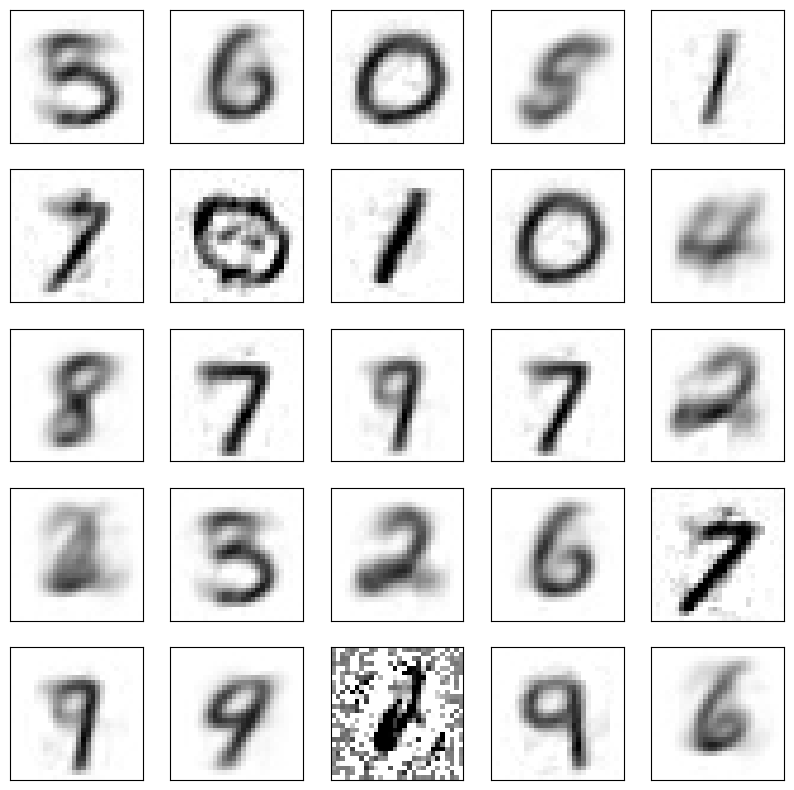

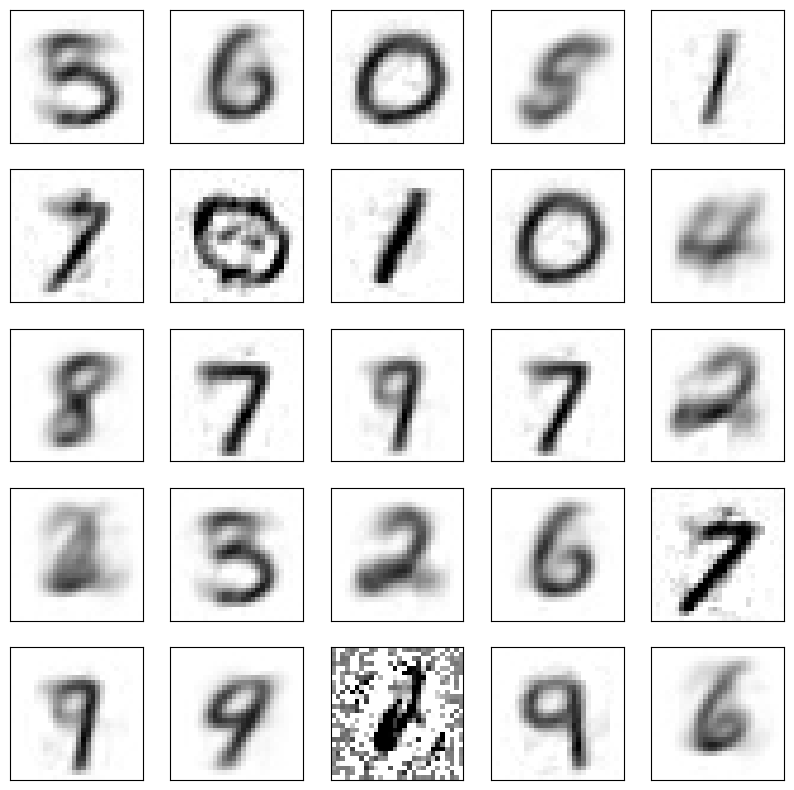

In [20]:
#task a 
z_samples = torch.randn(25, 2, device=device)
print(z_samples.shape)
z_decodings = model.decode(z_samples).detach()
plot_images(z_decodings)

torch.Size([25, 2])
tensor([[ 1.5056, -0.7525],
        [ 0.2835, -0.7653],
        [ 0.5211, -0.2939],
        [-0.1076,  0.3425],
        [-0.6348,  0.3835]], device='cuda:0')


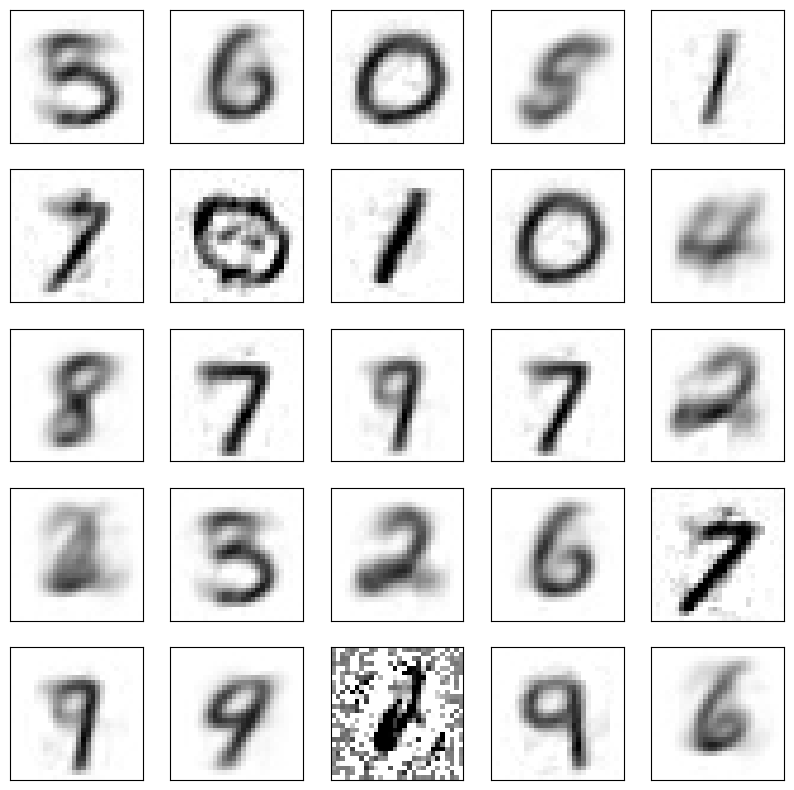

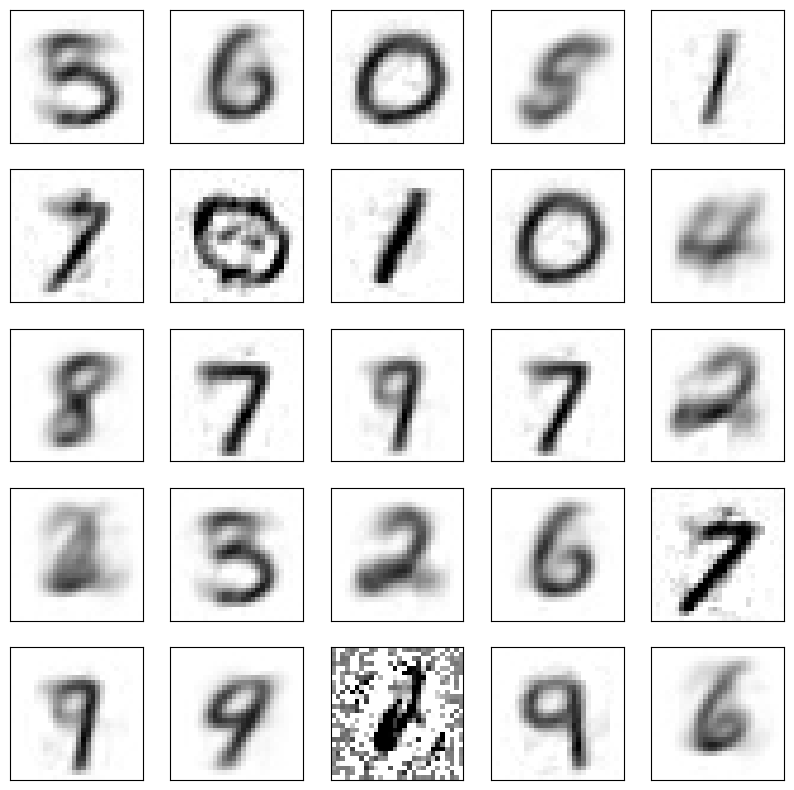

In [23]:
import torch.distributions as td
T = 0.9
mu_decode = torch.zeros(1, 2).to(device)
cov = (torch.tensor([[1.0, 0.0], [0.0, 1.0]]) * T**2).to(device)
mvn = td.MultivariateNormal(loc=mu_decode, covariance_matrix=cov)
samples = mvn.sample([25]).squeeze(1).to(device)
print(samples.shape)
print(samples[:5])
samples = model.decode(z_samples).detach()
plot_images(samples)

## Summary

We have trained a variational autoencoder that allows us to generate MNIST-like images. Adding a nonlinearity and an encoder seems to improve the quality of the samples. However, we also notice that the model is not perfect. Many further modifications of the decoder and encoder models are possible and could potentially improve the sampler. For instance, the dimension of the latent space can be increased (then the information loss by encoding the images in the latent space should be reduced). Alternatively the nonlinear decoder model can be changed: a more flexible model with increased number of layers in the neural network or a diagonal (or even full) covariance matrix could be used, or the outputs could be restricted to values between 0 and 1 (since we represent MNIST images as vectors with entries between 0 and 1).